# Training models on campaigns in the same area 
## Operator 1

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from keras.models import Sequential # type: ignore
from keras.layers import Dense, LSTM # type: ignore
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go

In [6]:
rsrp_colors = ['#384959', '#6A89A7', '#88BDF2', '#BDDDFC']
rsrq_colors = ['#614419', '#B37E2E', '#DB9A39', '#FFB343']
sinr_colors = ['#135E4B', '#4CB572', '#A1D8B5', '#CCDCDB']
mode_colors = ['#872323', '#C93636', '#E26666', '#F4B6B6']

### Prossessing functions

In [7]:
'''
    Reading the dataset and returning two pandas DataFrames:
        The first DataFrame containing every datapoint belonging to the given campaign (if any)
        The second DataFrame containing only one column - the mode (4G or 5G)
'''
def read_dataset(filename, campaigns=None, features=None):
    df = pd.read_csv(filename)
    df = df.loc[:, ~df.columns.str.match('Unnamed')]
    df = df.loc[:, ~df.columns.str.match('Timestamp')]
    df = df.replace('DC', 1)
    df = df.replace('LTE', 0)
    df = df[df['campaign'].str.contains('Driving') | df['campaign'].str.contains('Walking')]

    if campaigns != None:
        df = df[df['campaign'].isin(campaigns)]

    if features == None:
        features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'campaign']

    features.append('Mode')
    features.append('Latitude')
    features.append('Longitude')
    return df[features]

### LSTM functions

In [8]:
'''
    Returns a numpy array of list 
'''
def series_split_sequences(f, t, n_steps_in, n_steps_out):
    X, y = [], []
    curr_campaign = ''
    for i in range(len(f)):
        # find the end of the pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        if out_end_ix > len(f):
            break

        if curr_campaign == '': # set new current campaign if there is no campaign
            curr_campaign = f['campaign'].iloc[i]
        seq_x, seq_y = f[i:end_ix], t[end_ix:out_end_ix]
        if f.iloc[i:out_end_ix]['campaign'].nunique() > 1: # check to see if in transition between two campaigns
            continue
        elif curr_campaign != f['campaign'].iloc[i]: # set new campaign equal to current if this is the campaign we are looping through
            curr_campaign = f['campaign'].iloc[i]
        X.append(seq_x.drop('campaign', axis=1))
        y.append(seq_y)

    return np.array(X), np.array(y)


'''
    Returns the mean absolute error on each datapoint
'''
def single_point_mae(y_pred, y_true):
    pred_series, true_series = [], []

    for i in range(len(y_pred)):
        for k in range(len(y_pred[i])):
            pred_series.append(y_pred[i][k])
            true_series.append(y_true[i][k])

    pred_series, true_series = np.array(pred_series), np.array(true_series)

    return np.mean(np.abs(pred_series - true_series)), np.abs(pred_series - true_series)


def long_short_term_memory(train, test, target_feature:str, features:list, campaigns:list, test_campaigns:list, n_steps_in=5, n_steps_out=1, n_first_units=5, n_second_units=10):

    features.remove('campaign')

    idx_target = features.index(target_feature)

    scaler = MinMaxScaler()
    train[features] = scaler.fit_transform(train[features])
    test[features] = scaler.transform(test[features])

    X, y = series_split_sequences(train, train[target_feature], n_steps_in, n_steps_out)
    X_test, y_test = series_split_sequences(test, test[target_feature], n_steps_in, n_steps_out)

    train_idx = 4 * len(y) // 5

    X_train, y_train = X[0 : train_idx], y[0 : train_idx]
    X_val, y_val = X[train_idx ::], y[train_idx ::]

    # optimizer = RMSprop(learning_rate=0.001, rho=0.9) # , epsilon=None) 

    model = Sequential()
    model.add(LSTM(units=n_first_units,
                   activation='relu', recurrent_activation='sigmoid',
                   return_sequences=True, return_state=False
                   ))
    # model.add(Dropout(0.2))
    model.add(LSTM(units=n_second_units,
                   activation='relu', recurrent_activation='sigmoid',
                   return_sequences=False, return_state=False
                   ))
    # model.add(Dropout(0.2))
    model.add(Dense(n_steps_out, activation='sigmoid'))
    model.compile(loss='mse', optimizer='adam')
    
    history = model.fit(X_train, y_train,
              epochs=100,
              validation_data=(X_val, y_val),
              shuffle=True, verbose=0)   

    scaler_pred = MinMaxScaler()
    scaler_pred.min_, scaler_pred.scale_ = scaler.min_[idx_target], scaler.scale_[idx_target]

    # prepare test data for plots
    if len(test_campaigns) == 1:
        y_pred = model.predict(X_test, verbose=0) 

        y_pred = scaler_pred.inverse_transform(y_pred)
        y_true = scaler_pred.inverse_transform(y_test)
        test[features] = scaler.inverse_transform(test[features])

        y_true_plot = test[target_feature].values
        y_pred_plot = np.empty_like(test)
        y_pred_plot[:, :] = np.nan
        y_pred_plot[n_steps_in : len(test), :] = y_pred

        train_pred = model.predict(X, verbose=0)

        train_pred = scaler_pred.inverse_transform(train_pred)
        train[features] = scaler.inverse_transform(train[features])
        _, test_y_seq = series_split_sequences(train, train[target_feature], n_steps_in, n_steps_out)
        
        y_train_plot = train[target_feature].values
        train_pred_plot = np.empty_like(train)
        train_pred_plot[:, :] = np.nan
        train_pred_plot[n_steps_in : len(train), :] = train_pred

    else:
        test_test = test[test['campaign'] == test_campaigns[0]]
        test_seq, test_test_seq = series_split_sequences(test_test, test_test[target_feature], n_steps_in, n_steps_out)
        y_pred = model.predict(test_seq, verbose=0)

        y_pred = scaler_pred.inverse_transform(y_pred)
        y_true = scaler_pred.inverse_transform(test_test_seq)
        test_test[features] = scaler.inverse_transform(test_test[features])

        y_true_plot = test_test[target_feature].values
        y_pred_plot = np.empty_like(test_test)
        y_pred_plot[:, :] = np.nan
        y_pred_plot[n_steps_in : len(test_test), :] = y_pred

        test_train = train[train['campaign'] == campaigns[0]]
        test_train_seq, test_y_seq = series_split_sequences(test_train, test_train[target_feature], n_steps_in, n_steps_out)
        train_pred = model.predict(test_train_seq, verbose=0)

        train_pred = scaler_pred.inverse_transform(train_pred)
        test_train[features] = scaler.inverse_transform(test_train[features])
        test_y_seq = scaler_pred.inverse_transform(test_y_seq)

        y_train_plot = test_train[target_feature].values
        train_pred_plot = np.empty_like(test_train)
        train_pred_plot[:, :] = np.nan
        train_pred_plot[n_steps_in : len(test_train), :] = train_pred

    mae = single_point_mae(y_pred, y_true)
    train_mae = single_point_mae(train_pred, test_y_seq)

    results = {'y_pred': y_pred_plot,
               'y_true': y_true_plot,
               'train_pred': train_pred_plot,
               'train_true': y_train_plot,
               'loss' : history.history['loss'],
               'loss_final' : round(history.history['loss'][-1], 5),
               'val_loss' : history.history['val_loss'],
               'val_loss_final' : round(history.history['val_loss'][-1], 5),
               'mae': round(mae[0], 2),
               'list_mae': mae[1],
               'train_mae': round(train_mae[0], 2),
               'train_list_mae': train_mae[1]
               }

    return results

### Random Forest functions

In [9]:
def rf(X_train, X_test, mode_train, mode_test, campaigns, test_campaigns, features, n_estimators=100, max_depth=None, min_samples_leaf=1):
    permutation = np.random.permutation(X_train.index)
    X_train_randomized = X_train.reindex(permutation).reset_index(drop=True)
    mode_train_randomized = mode_train.reindex(permutation).reset_index(drop=True)

    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    smote = SMOTE()
    # rus = RandomUnderSampler() 
    X_train_balanced, mode_train_balanced = smote.fit_resample(X_train_randomized[features], mode_train_randomized['Mode'])
    # X_train_balanced, mode_train_balanced = rus.fit_resample(X_train_balanced, mode_train_balanced)

    rf.fit(X_train_balanced, mode_train_balanced)

    if len(test_campaigns) == 1:
        y_pred = rf.predict(X_test[features])

        accuracy = accuracy_score(mode_test['Mode'], y_pred)
        precision = precision_score(mode_test['Mode'], y_pred)
        recall = recall_score(mode_test['Mode'], y_pred)

        y_true = mode_test['Mode']

        

        train_pred = rf.predict(X_train[features])

        train_accuracy = accuracy_score(mode_train['Mode'], train_pred)
        train_precision = precision_score(mode_train['Mode'], train_pred)
        train_recall = recall_score(mode_train['Mode'], train_pred)

        train_true = mode_train['Mode']
    else:
        X_test_test = X_test[X_test['campaign'] == test_campaigns[0]]
        X_test_mode = mode_test[mode_test['campaign'] == test_campaigns[0]]
        
        y_pred = rf.predict(X_test_test[features])

        y_pred_total = rf.predict(X_test[features])
        accuracy = accuracy_score(mode_test['Mode'], y_pred_total)
        precision = precision_score(mode_test['Mode'], y_pred_total)
        recall = recall_score(mode_test['Mode'], y_pred_total)

        y_true = X_test_mode['Mode']

        X_train_test = X_train[X_train['campaign'] == campaigns[0]]
        X_train_mode = mode_train[mode_train['campaign'] == campaigns[0]]

        train_pred = rf.predict(X_train_test[features])

        train_pred_total = rf.predict(X_train[features])
        train_accuracy = accuracy_score(mode_train['Mode'], train_pred_total)
        train_precision = precision_score(mode_train['Mode'], train_pred_total)
        train_recall = recall_score(mode_train['Mode'], train_pred_total)

        train_true = X_train_mode['Mode']

    results = {'Accuracy': round(accuracy, 3),
               'Precision': round(precision, 3),
               'Recall': round(recall, 3),
               'y_true' : y_true,
               'y_pred' : y_pred,
               'train_true': train_true,
               'train_pred': train_pred,
               'Accuracy_train': round(train_accuracy, 3),
               'Precision_train': round(train_precision, 3),
               'Recall_train': round(train_recall, 3),
               'model': rf}
    return results

In [10]:
# Parameters
tf.random.set_seed(4567)
dataset = 'datasets/Op1_merged.csv'
operator = 'Operator 1'

# LSTM
n_steps_in = 2
n_steps_out = 1

n_first_units = 5
n_second_units = 10

# Random Forest
n_estimators = 100
max_depth = 10

NameError: name 'tf' is not defined

In [ ]:
op1_df = read_dataset(dataset)
op1_campaigns = op1_df['campaign'].unique().tolist()

In [ ]:
fig = go.Figure()

for campaign in op1_campaigns:
    current_route = op1_df[op1_df['campaign'] == campaign]
    fig.add_trace(go.Scattermapbox(lat=current_route['Latitude'], lon=current_route['Longitude'],
                                       marker = dict(
                                           opacity = 0.6,
                                           size = 3
                                       ),
                                       name=campaign))

fig.update_layout(
    height=420,
    mapbox=dict(
        style='carto-positron',
        zoom=11,
        center=dict(lon=op1_df['Longitude'].mean(), lat=op1_df['Latitude'].mean())
    ),
    margin=dict(
        t=1,
        b=1,
        r=1,
        l=1
    )
)
fig.show()

### Overlapping campaigns from dataset

* Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi, Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi_Test_2_No_Flight_Mode, Ping_UNIDATA_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode, Interactivity_gaming_4G5G_TIM_Driving_Viale_Marconi_No_Flight_Mode, Interactivity_gaming_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode, Capacity_Ookla_UNIDATA_4G5G_TIM_Driving_Viale_Marconi

* Ping_UNIDATA_4G5G_TIM_Walking_Termini_to_DIET, Ping_UNIDATA_4G5G_TIM_Walking_DIET_to_Termini, Ping_UNIDATA_4G5G_TIM_Walking_DIET_to_Labicana_Hotel, Interactivity_gaming_4G5G_TIM_Walking_Termini_to_DIET_Test_2_No_Flight_Mode, Capacity_Ookla_UNIDATA_4G5G_TIM_Walking_DIET_to_Labicana_Hotel

* Ping_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia, Ping_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia_Part_2, Interactivity_gaming_4G5G_TIM_Driving_Tuscolana_Stat_Appia_No_Flight_Mode, Capacity_Ookla_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia, Capacity_Ookla_4G5G_TIM_Driving_Tuscolana_Stat_Appia_No_Flight_Mode

* Ping_UNIDATA_4G5G_TIM_Driving_Luca, Interactivity_gaming_4G5G_TIM_Driving_Luca, Capacity_Ookla_4G5G_Tim_Driving_Luca

In [ ]:
overlap_1 = ['Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi_Test_2_No_Flight_Mode',
             'Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi',
             'Interactivity_gaming_4G5G_TIM_Driving_Viale_Marconi_No_Flight_Mode', 
             'Capacity_Ookla_UNIDATA_4G5G_TIM_Driving_Viale_Marconi',
             'Interactivity_gaming_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode',
             'Ping_UNIDATA_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode']

overlap_2 = ['Ping_UNIDATA_4G5G_TIM_Walking_Termini_to_DIET', 
             'Ping_UNIDATA_4G5G_TIM_Walking_DIET_to_Termini', 
             'Ping_UNIDATA_4G5G_TIM_Walking_DIET_to_Labicana_Hotel', 
             'Interactivity_gaming_4G5G_TIM_Walking_Termini_to_DIET_Test_2_No_Flight_Mode', 
             'Capacity_Ookla_UNIDATA_4G5G_TIM_Walking_DIET_to_Labicana_Hotel']

overlap_3 = ['Ping_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia', 
             'Ping_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia_Part_2', 
             'Interactivity_gaming_4G5G_TIM_Driving_Tuscolana_Stat_Appia_No_Flight_Mode', 
             'Capacity_Ookla_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia', 
             'Capacity_Ookla_4G5G_TIM_Driving_Tuscolana_Stat_Appia_No_Flight_Mode']

overlap_4 = ['Ping_UNIDATA_4G5G_TIM_Driving_Luca', 
             'Interactivity_gaming_4G5G_TIM_Driving_Luca', 
             'Capacity_Ookla_4G5G_Tim_Driving_Luca']

In [ ]:
train = read_dataset(dataset, campaigns=[overlap_1[1]])
test = read_dataset(dataset, campaigns=[overlap_1[0]])

## LSTM

In [ ]:
target_features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']
feature_selection = [#['RSRP'], ['SINR'], ['RSRQ'], 
                     ['RSRP', 'SINR'], ['RSRP', 'RSRQ'], ['SINR', 'RSRQ'], ['RSRP', 'SINR', 'RSRQ'],
                     #['SSS_RSRP'], ['SSS_SINR'], ['SSS_RSRQ'],
                     ['SSS_RSRP', 'SSS_SINR'], ['SSS_RSRP', 'SSS_RSRQ'], ['SSS_SINR', 'SSS_RSRQ'], ['SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'],
                     ['RSRP', 'SSS_RSRP'], ['SINR', 'SSS_SINR'], ['RSRQ', 'SSS_RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']]

lstm_results = {}

In [ ]:
for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            # print(used_features)
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=train['campaign'].unique().tolist(), test_campaigns=test['campaign'].unique().tolist(), n_first_units=n_first_units, n_second_units=n_second_units)

In [ ]:
df_lstm_results = pd.DataFrame.from_dict(lstm_results, orient='index')

df_lstm_results.reset_index(inplace=True)
df_lstm_results.rename(columns={'index': 'Combination'}, inplace=True)
df_lstm_results = df_lstm_results.drop(['y_pred', 'y_true', 'train_pred', 'train_true', 'loss', 'val_loss', 'list_mae', 'train_list_mae'], axis=1)
df_lstm_results

Combination  loss_final  val_loss_final  \
0                         RSRP, SINR -> RSRP     0.00183         0.00168   
1                         RSRP, RSRQ -> RSRP     0.00197         0.00198   
2                   RSRP, SINR, RSRQ -> RSRP     0.00205         0.00213   
3                     RSRP, SSS_RSRP -> RSRP     0.00186         0.00245   
4                                All -> RSRP     0.00188         0.00216   
5                         RSRP, SINR -> SINR     0.00143         0.00133   
6                         SINR, RSRQ -> SINR     0.00155         0.00247   
7                   RSRP, SINR, RSRQ -> SINR     0.00149         0.00287   
8                     SINR, SSS_SINR -> SINR     0.00148         0.00267   
9                                All -> SINR     0.00152         0.00121   
10                        RSRP, RSRQ -> RSRQ     0.00340         0.00120   
11                        SINR, RSRQ -> RSRQ     0.00346         0.00117   
12                  RSRP, SINR, RSRQ -> RSRQ     0.00343         0.00166   
13                    RSRQ, SSS_RSRQ -> RSRQ     0.00365         0.00156   
14                               All -> RSRQ     0.00354         0.00124   
15            SSS_RSRP, SSS_SINR -> SSS_RSRP     0.00196         0.00129   
16            SSS_RSRP, SSS_RSRQ -> SSS_RSRP     0.00191         0.00130   
17  SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_RSRP     0.00195         0.00134   
18                RSRP, SSS_RSRP -> SSS_RSRP     0.00192         0.00129   
19                           All -> SSS_RSRP     0.00194         0.00129   
20            SSS_RSRP, SSS_SINR -> SSS_SINR     0.00250         0.00205   
21            SSS_SINR, SSS_RSRQ -> SSS_SINR     0.00243         0.00173   
22  SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_SINR     0.00242         0.00200   
23                SINR, SSS_SINR -> SSS_SINR     0.00255         0.00204   
24                           All -> SSS_SINR     0.00246         0.00186   
25            SSS_RSRP, SSS_RSRQ -> SSS_RSRQ     0.00282         0.00087   
26            SSS_SINR, SSS_RSRQ -> SSS_RSRQ     0.00291         0.00138   
27  SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_RSRQ     0.00279         0.00085   
28                RSRQ, SSS_RSRQ -> SSS_RSRQ     0.00307         0.00083   
29                           All -> SSS_RSRQ     0.00285         0.00107   

     mae  train_mae  
0   1.12       1.09  
1   0.73       1.01  
2   0.61       0.90  
3   0.85       1.14  
4   1.11       1.16  
5   0.70       0.85  
6   0.51       0.91  
7   0.50       0.88  
8   0.43       0.82  
9   0.61       0.78  
10  0.34       0.36  
11  0.31       0.35  
12  0.41       0.47  
13  0.46       0.49  
14  0.40       0.41  
15  1.06       1.03  
16  1.08       1.01  
17  1.05       1.00  
18  1.00       1.01  
19  1.05       1.02  
20  1.21       1.16  
21  1.20       1.11  
22  1.22       1.18  
23  0.99       1.02  
24  1.22       1.16  
25  0.54       0.43  
26  0.56       0.44  
27  0.61       0.39  
28  0.50       0.45  
29  0.55       0.39

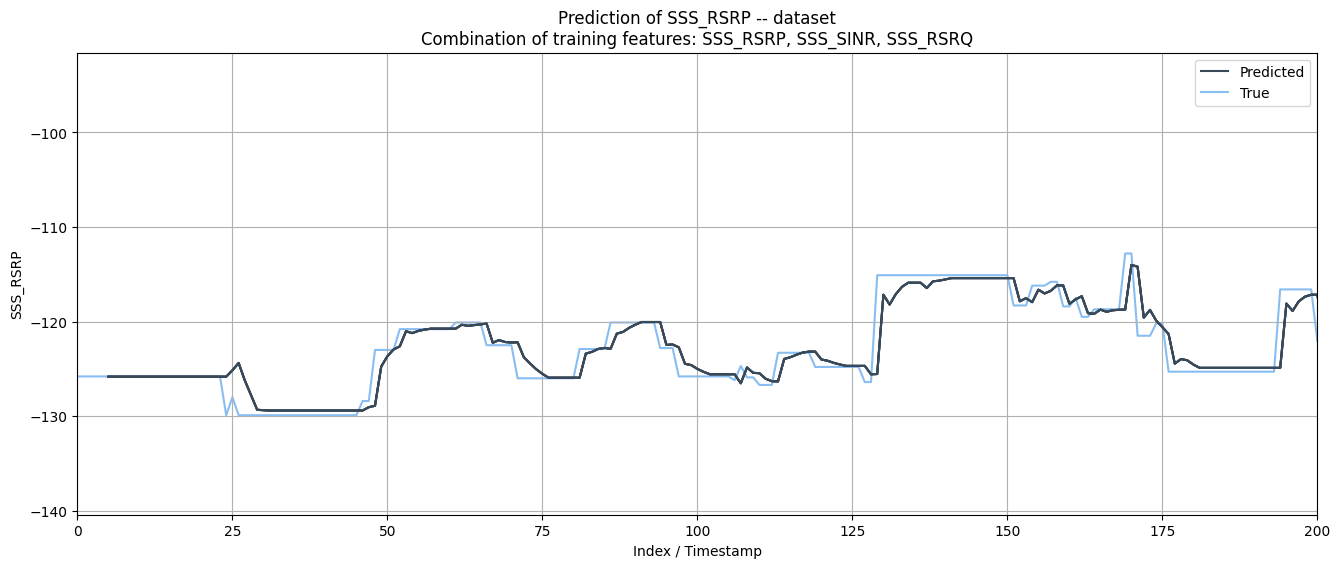

In [ ]:
selected_sss_rsrp_comb = 'SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_RSRP'
sss_rsrp_comb = lstm_results[selected_sss_rsrp_comb]
sss_rsrp_pred = sss_rsrp_comb['y_pred']
sss_rsrp_true = sss_rsrp_comb['y_true']
sss_rsrp_train_pred = sss_rsrp_comb['train_pred']
sss_rsrp_train_true = sss_rsrp_comb['train_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
pred = plt.plot(sss_rsrp_pred, label='Predicted', color=rsrp_colors[0], zorder=2)
true = plt.plot(sss_rsrp_true, label='True', color=rsrp_colors[2], zorder=1)
plt.xlabel('Index / Timestamp')
plt.ylabel('SSS_RSRP')
plt.xlim((0, 200))
plt.title(f'Prediction of SSS_RSRP -- {operator}\nCombination of training features: SSS_RSRP, SSS_SINR, SSS_RSRQ')
plt.legend(handles=[pred[0], true[0]])
plt.show()

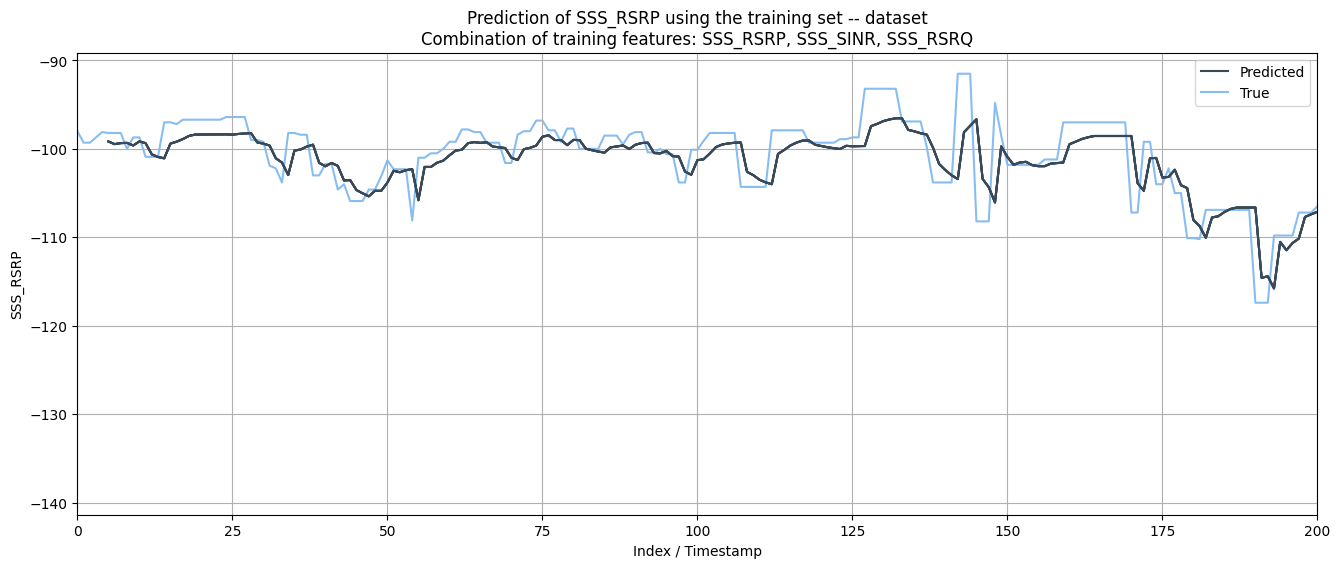

In [ ]:
f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
pred = plt.plot(sss_rsrp_train_pred, label='Predicted', color=rsrp_colors[0], zorder=2)
true = plt.plot(sss_rsrp_train_true, label='True', color=rsrp_colors[2], zorder=1)
plt.xlabel('Index / Timestamp')
plt.xlim((0, 200))
plt.ylabel('SSS_RSRP')
plt.title(f'Prediction of SSS_RSRP using the training set -- {operator}\nCombination of training features: SSS_RSRP, SSS_SINR, SSS_RSRQ')
plt.legend(handles=[pred[0], true[0]])
plt.show()

## Random Forest

In [ ]:
est_try = [5, 10, 20, 50, 80, 100, 120, 150, 200, 250, 300]
min_leaf_size = [1, 2, 5, 7, 9, 12, 15]

### Overlap 1

#### Train 1 campaign -- Test 1 campaign

In [ ]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.append('campaign')
features = feature_selection[-1]
campaigns = train['campaign'].unique().tolist()
test_campaigns = test['campaign'].unique().tolist()

for est in est_try:
    for leaf in min_leaf_size:
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
df_rf_results

KeyboardInterrupt: 

In [ ]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.561
Mean precision: 0.573
Mean recall: 0.110


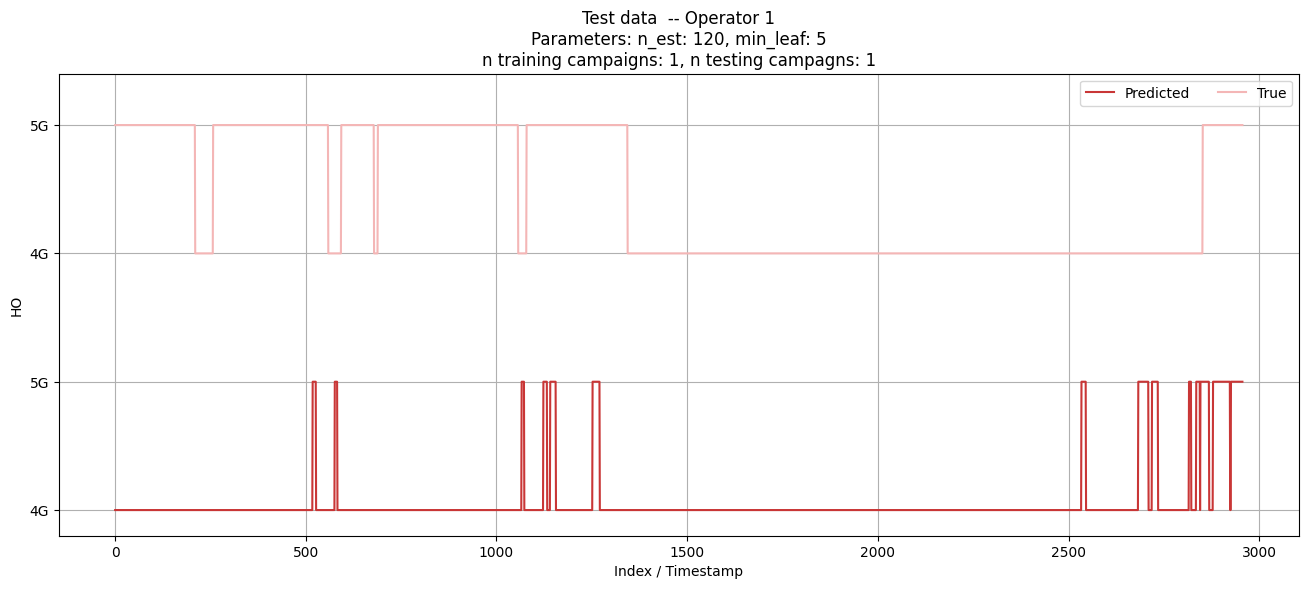

In [ ]:
selected_rf_comb = 'n_est: 120, min_leaf: 5'
rf_comb = rf_results[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rf_pred, color=mode_colors[1], label='Predicted', zorder=2)
plt.plot(rf_true.values + 2, color=mode_colors[3], label='True', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.4))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Test data  -- {operator}\nParameters: {selected_rf_comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
plt.legend(ncols=3, loc='best')
plt.show()

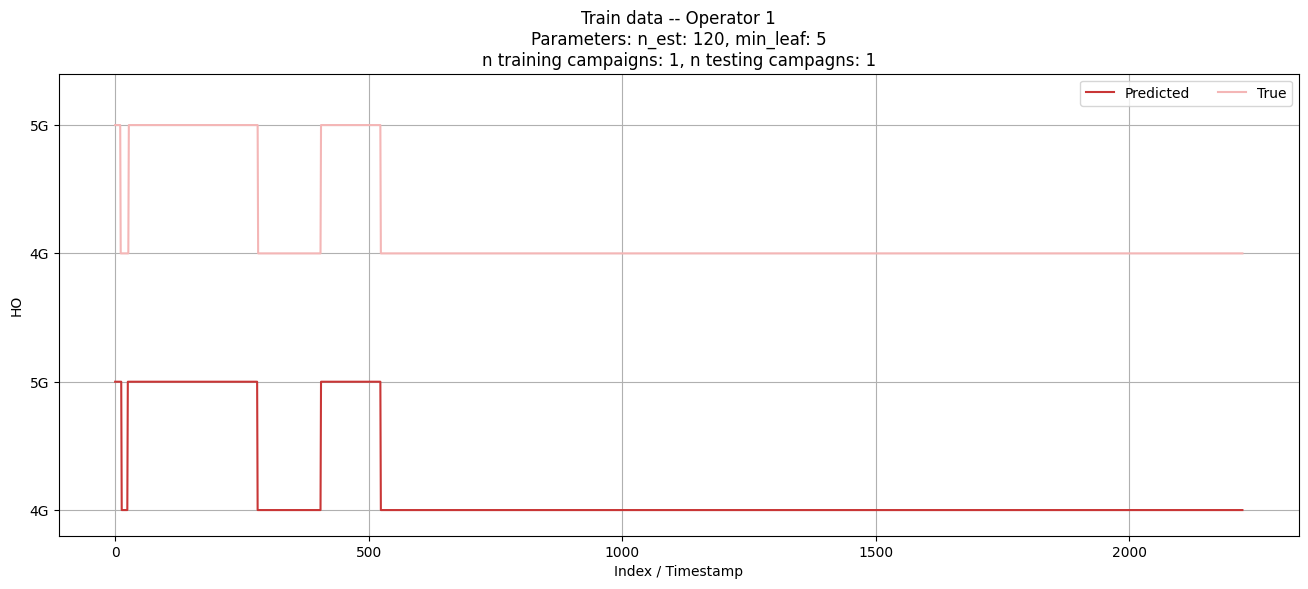

In [ ]:
rf_pred_train = rf_comb['train_pred']
rf_true_train = rf_comb['train_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rf_pred_train, color=mode_colors[1], label='Predicted', zorder=2)
plt.plot(rf_true_train.values + 2, color=mode_colors[3], label='True', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.4))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Train data -- dataset\nParameters: {selected_rf_comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
plt.legend(ncols=3, loc='best')
plt.show()

##### Include location

In [ ]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.extend(['campaign', 'Latitude', 'Longitude'])
features = feature_selection[-1].copy()
features.extend(['Latitude', 'Longitude'])

for est in est_try:
    for leaf in min_leaf_size:
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=train['campaign'].unique().tolist(), test_campaigns=test['campaign'].unique().tolist(), n_estimators=est, min_samples_leaf=leaf, features=features)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
df_rf_results

Parameters  Accuracy  Precision  Recall  Accuracy_train  \
0      n_est: 5, min_leaf: 1     0.540      0.441   0.070           0.999   
1      n_est: 5, min_leaf: 2     0.542      0.463   0.079           0.999   
2      n_est: 5, min_leaf: 5     0.535      0.422   0.079           0.997   
3      n_est: 5, min_leaf: 7     0.522      0.365   0.079           0.996   
4      n_est: 5, min_leaf: 9     0.518      0.352   0.079           0.992   
..                       ...       ...        ...     ...             ...   
72   n_est: 300, min_leaf: 5     0.527      0.385   0.079           0.998   
73   n_est: 300, min_leaf: 7     0.527      0.385   0.079           0.994   
74   n_est: 300, min_leaf: 9     0.523      0.370   0.079           0.994   
75  n_est: 300, min_leaf: 12     0.527      0.385   0.079           0.992   
76  n_est: 300, min_leaf: 15     0.527      0.385   0.079           0.992   

    Precision_train  Recall_train  
0             0.995         1.000  
1             0.995         0.997  
2             0.985         1.000  
3             0.977         1.000  
4             0.955         1.000  
..              ...           ...  
72            0.990         1.000  
73            0.967         1.000  
74            0.967         1.000  
75            0.958         1.000  
76            0.958         1.000  

[77 rows x 7 columns]

In [ ]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.526
Mean precision: 0.384
Mean recall: 0.079


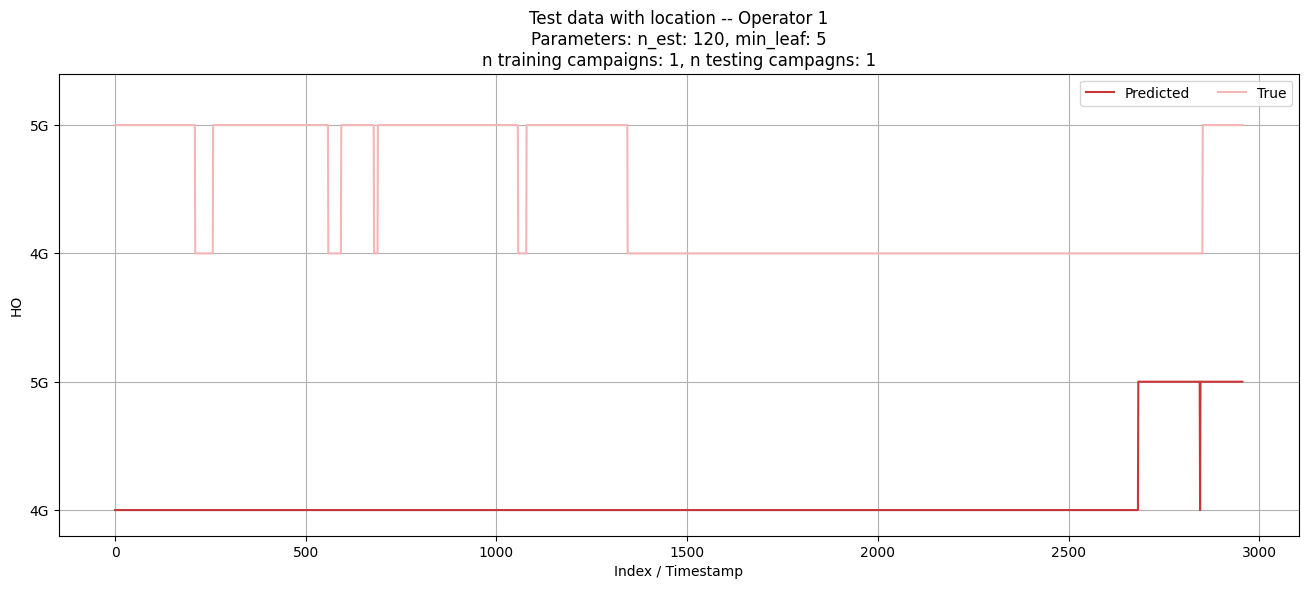

In [ ]:
selected_rf_comb = 'n_est: 120, min_leaf: 5'
rf_comb = rf_results[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rf_pred, color=mode_colors[1], label='Predicted', zorder=2)
plt.plot(rf_true.values + 2, color=mode_colors[3], label='True', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.4))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Test data with location -- {operator}\nParameters: {selected_rf_comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
plt.legend(ncols=3, loc='best')
plt.show()

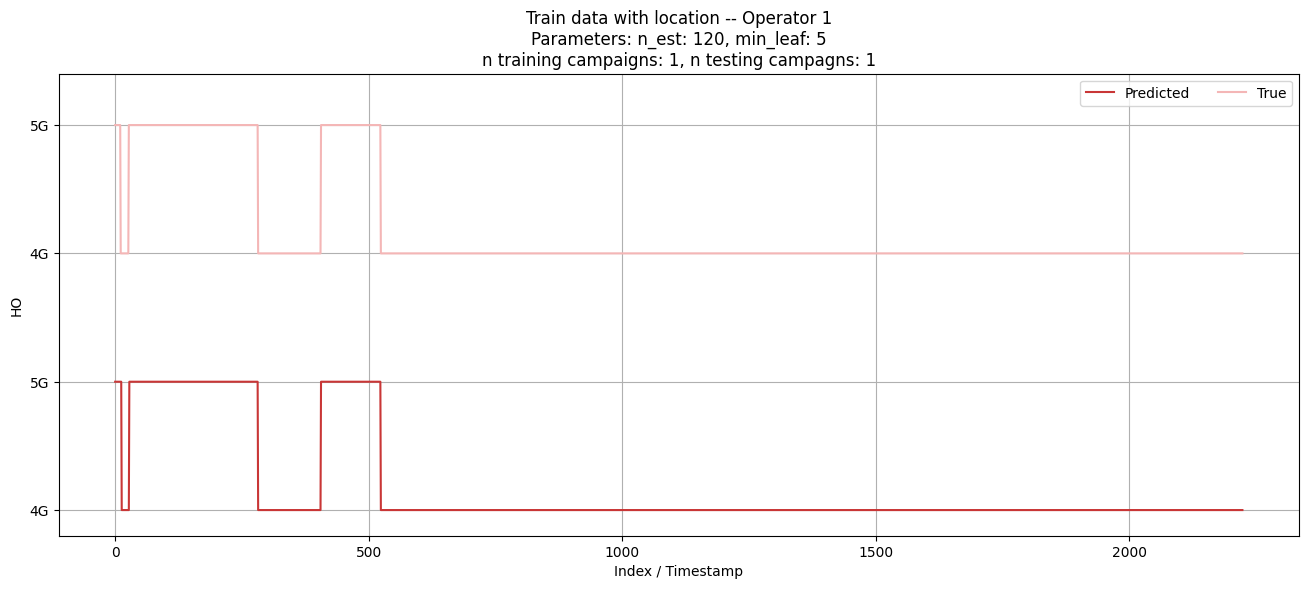

In [ ]:
rf_pred_train = rf_comb['train_pred']
rf_true_train = rf_comb['train_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rf_pred_train, color=mode_colors[1], label='Predicted', zorder=2)
plt.plot(rf_true_train.values + 2, color=mode_colors[3], label='True', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.4))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Train data with location -- {operator}\nParameters: {selected_rf_comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
plt.legend(ncols=3, loc='best')
plt.show()

#### Train 2 campaigns -- Test 1 campaign

In [ ]:
train = read_dataset(dataset, campaigns=overlap_1[1:3])
test = read_dataset(dataset, campaigns=[overlap_1[0]])
campaigns = train['campaign'].unique().tolist()
test_campaigns = test['campaign'].unique().tolist()

In [ ]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.append('campaign')
features = feature_selection[-1]

for est in est_try:
    for leaf in min_leaf_size:
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
df_rf_results

Parameters  Accuracy  Precision  Recall  Accuracy_train  \
0      n_est: 5, min_leaf: 1     0.638      0.685   0.370           0.998   
1      n_est: 5, min_leaf: 2     0.611      0.639   0.321           0.997   
2      n_est: 5, min_leaf: 5     0.631      0.680   0.347           0.991   
3      n_est: 5, min_leaf: 7     0.644      0.691   0.384           0.985   
4      n_est: 5, min_leaf: 9     0.637      0.673   0.381           0.975   
..                       ...       ...        ...     ...             ...   
72   n_est: 300, min_leaf: 5     0.636      0.668   0.386           0.995   
73   n_est: 300, min_leaf: 7     0.640      0.685   0.376           0.992   
74   n_est: 300, min_leaf: 9     0.628      0.661   0.361           0.987   
75  n_est: 300, min_leaf: 12     0.631      0.656   0.384           0.985   
76  n_est: 300, min_leaf: 15     0.628      0.662   0.361           0.984   

    Precision_train  Recall_train  
0             0.995         0.997  
1             0.994         0.998  
2             0.979         0.993  
3             0.975         0.978  
4             0.938         0.986  
..              ...           ...  
72            0.991         0.993  
73            0.985         0.991  
74            0.967         0.991  
75            0.964         0.988  
76            0.964         0.987  

[77 rows x 7 columns]

In [ ]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.635
Mean precision: 0.676
Mean recall: 0.368


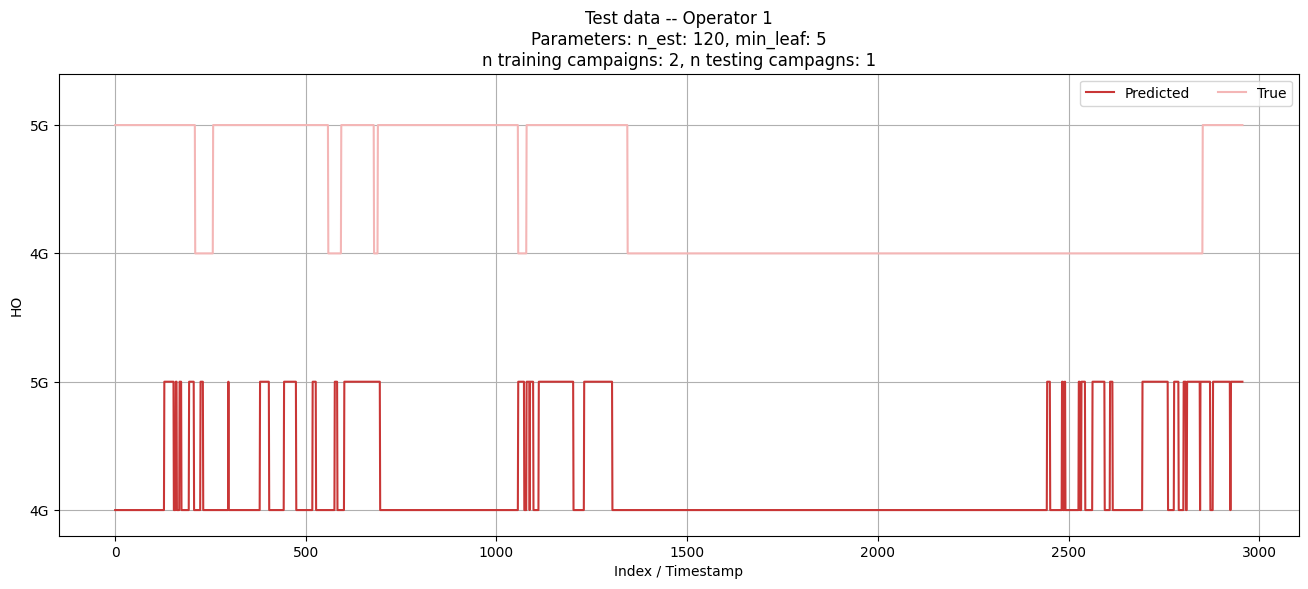

In [ ]:
selected_rf_comb = 'n_est: 120, min_leaf: 5'
rf_comb = rf_results[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rf_pred, color=mode_colors[1], label='Predicted', zorder=2)
plt.plot(rf_true.values + 2, color=mode_colors[3], label='True', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.4))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Test data -- {operator}\nParameters: {selected_rf_comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
plt.legend(ncols=3, loc='best')
plt.show()

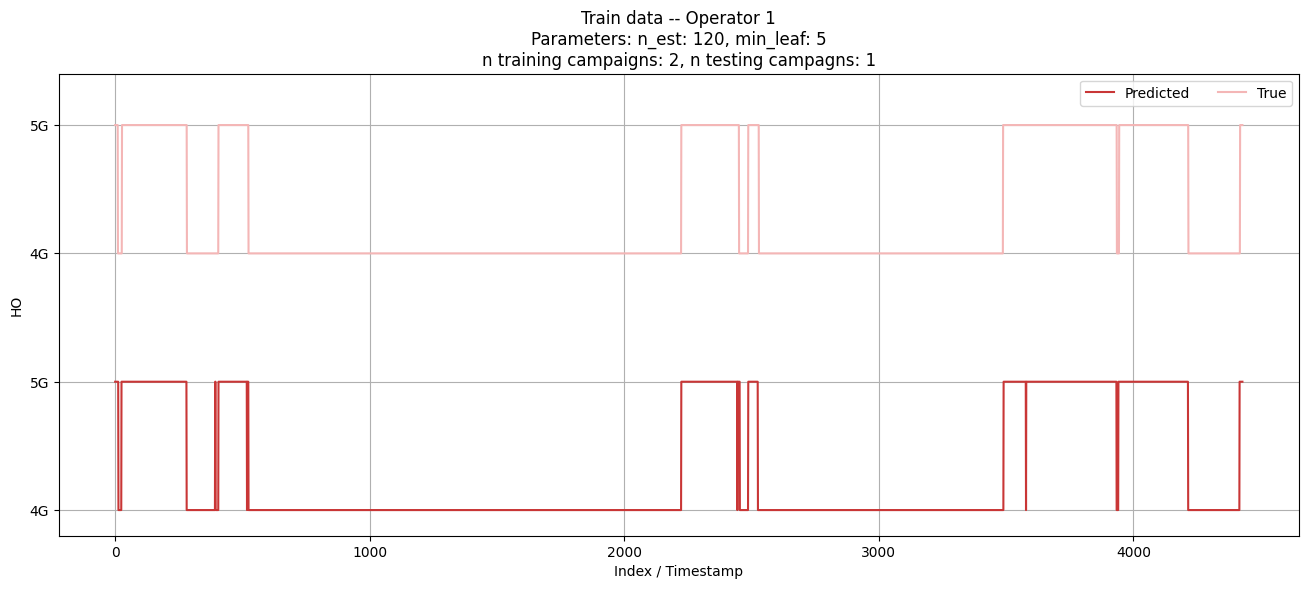

In [ ]:
rf_pred_train = rf_comb['train_pred']
rf_true_train = rf_comb['train_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rf_pred_train, color=mode_colors[1], label='Predicted', zorder=2)
plt.plot(rf_true_train.values + 2, color=mode_colors[3], label='True', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.4))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Train data -- {operator}\nParameters: {selected_rf_comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
plt.legend(ncols=3, loc='best')
plt.show()

#### Include location

In [ ]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.extend(['campaign', 'Latitude', 'Longitude'])
features = feature_selection[-1].copy()
features.extend(['Latitude', 'Longitude'])

for est in est_try:
    for leaf in min_leaf_size:
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=train['campaign'].unique().tolist(), test_campaigns=test['campaign'].unique().tolist(), n_estimators=est, min_samples_leaf=leaf, features=features)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
df_rf_results

Parameters  Accuracy  Precision  Recall  Accuracy_train  \
0      n_est: 5, min_leaf: 1     0.680      0.747   0.441           0.999   
1      n_est: 5, min_leaf: 2     0.711      0.771   0.513           0.998   
2      n_est: 5, min_leaf: 5     0.763      0.844   0.583           0.994   
3      n_est: 5, min_leaf: 7     0.684      0.735   0.470           0.992   
4      n_est: 5, min_leaf: 9     0.725      0.775   0.551           0.990   
..                       ...       ...        ...     ...             ...   
72   n_est: 300, min_leaf: 5     0.704      0.753   0.513           0.996   
73   n_est: 300, min_leaf: 7     0.700      0.755   0.498           0.995   
74   n_est: 300, min_leaf: 9     0.702      0.755   0.504           0.992   
75  n_est: 300, min_leaf: 12     0.698      0.752   0.496           0.991   
76  n_est: 300, min_leaf: 15     0.711      0.762   0.523           0.991   

    Precision_train  Recall_train  
0             0.998         0.999  
1             0.997         0.995  
2             0.988         0.994  
3             0.981         0.995  
4             0.973         0.996  
..              ...           ...  
72            0.990         0.998  
73            0.985         0.998  
74            0.977         0.998  
75            0.977         0.996  
76            0.977         0.995  

[77 rows x 7 columns]

In [ ]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.701
Mean precision: 0.751
Mean recall: 0.505


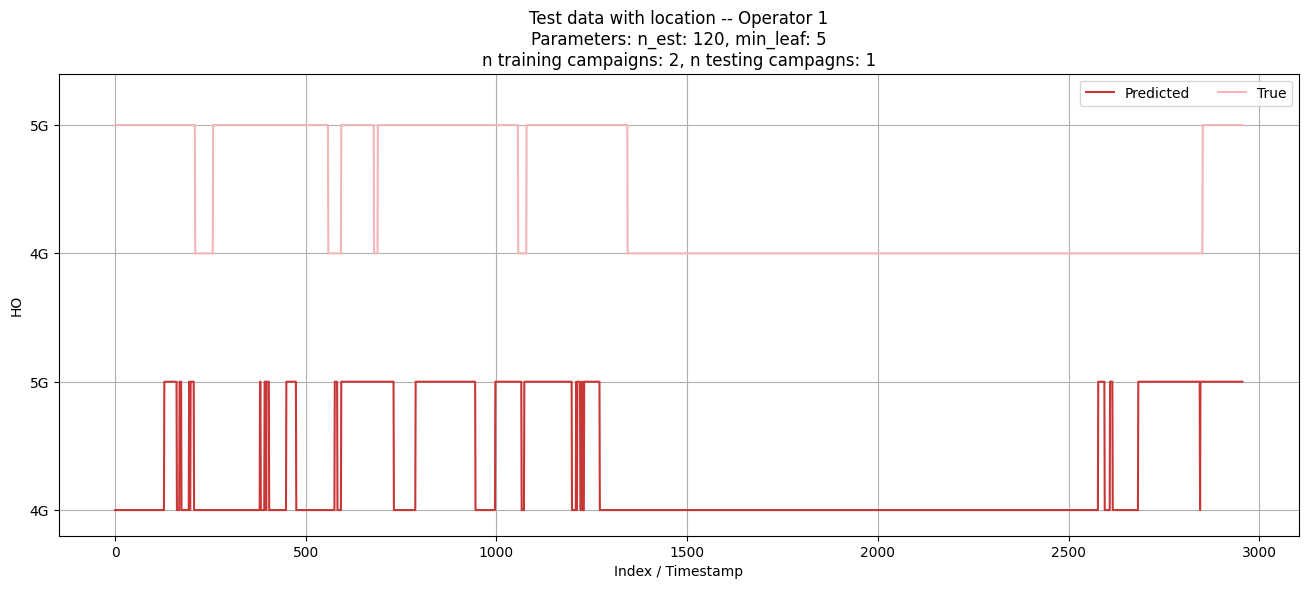

In [ ]:
selected_rf_comb = 'n_est: 120, min_leaf: 5'
rf_comb = rf_results[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rf_pred, color=mode_colors[1], label='Predicted', zorder=2)
plt.plot(rf_true.values + 2, color=mode_colors[3], label='True', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.4))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Test data with location -- {operator}\nParameters: {selected_rf_comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
plt.legend(ncols=3, loc='best')
plt.show()

### Train 3 campaigns -- Test 1 campaign

In [ ]:
train = read_dataset(dataset, campaigns=overlap_1[1:4])
test = read_dataset(dataset, campaigns=[overlap_1[0]])
campaigns = train['campaign'].unique().tolist()
test_campaigns = test['campaign'].unique().tolist()

In [ ]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.append('campaign')
features = feature_selection[-1]

for est in est_try:
    for leaf in min_leaf_size:
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
df_rf_results

Parameters  Accuracy  Precision  Recall  Accuracy_train  \
0      n_est: 5, min_leaf: 1     0.589      0.610   0.254           0.997   
1      n_est: 5, min_leaf: 2     0.647      0.720   0.359           0.996   
2      n_est: 5, min_leaf: 5     0.649      0.704   0.385           0.992   
3      n_est: 5, min_leaf: 7     0.624      0.698   0.297           0.992   
4      n_est: 5, min_leaf: 9     0.640      0.755   0.300           0.986   
..                       ...       ...        ...     ...             ...   
72   n_est: 300, min_leaf: 5     0.638      0.711   0.335           0.995   
73   n_est: 300, min_leaf: 7     0.636      0.716   0.324           0.993   
74   n_est: 300, min_leaf: 9     0.638      0.710   0.336           0.991   
75  n_est: 300, min_leaf: 12     0.642      0.734   0.324           0.988   
76  n_est: 300, min_leaf: 15     0.632      0.697   0.329           0.986   

    Precision_train  Recall_train  
0             0.994         0.996  
1             0.993         0.993  
2             0.978         0.991  
3             0.977         0.990  
4             0.957         0.990  
..              ...           ...  
72            0.986         0.994  
73            0.983         0.991  
74            0.974         0.992  
75            0.962         0.992  
76            0.957         0.989  

[77 rows x 7 columns]

In [ ]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.636
Mean precision: 0.712
Mean recall: 0.327


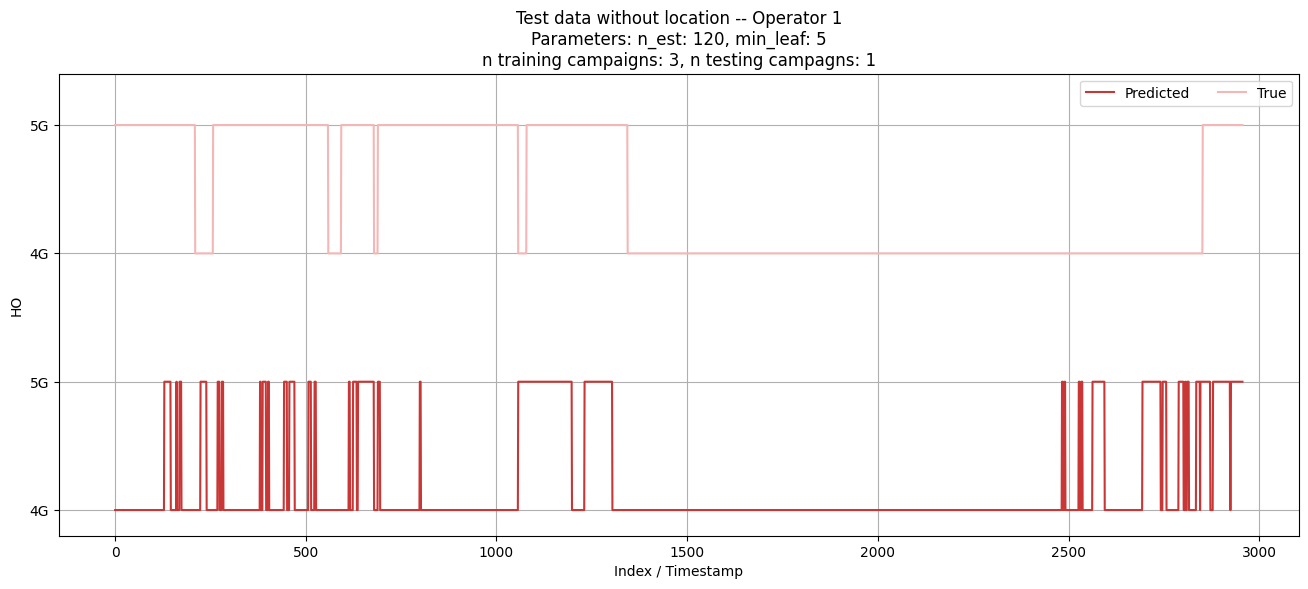

In [ ]:
selected_rf_comb = 'n_est: 120, min_leaf: 5'
rf_comb = rf_results[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rf_pred, color=mode_colors[1], label='Predicted', zorder=2)
plt.plot(rf_true.values + 2, color=mode_colors[3], label='True', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.4))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Test data without location -- {operator}\nParameters: {selected_rf_comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
plt.legend(ncols=3, loc='best')
plt.show()

#### Include location

In [ ]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.extend(['campaign', 'Latitude', 'Longitude'])
features = feature_selection[-1].copy()
features.extend(['Latitude', 'Longitude'])

for est in est_try:
    for leaf in min_leaf_size:
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=train['campaign'].unique().tolist(), test_campaigns=test['campaign'].unique().tolist(), n_estimators=est, min_samples_leaf=leaf, features=features)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
df_rf_results

Parameters  Accuracy  Precision  Recall  Accuracy_train  \
0      n_est: 5, min_leaf: 1     0.653      0.832   0.290           0.999   
1      n_est: 5, min_leaf: 2     0.704      0.942   0.367           0.999   
2      n_est: 5, min_leaf: 5     0.708      0.869   0.416           0.994   
3      n_est: 5, min_leaf: 7     0.685      0.877   0.353           0.994   
4      n_est: 5, min_leaf: 9     0.722      0.916   0.424           0.990   
..                       ...       ...        ...     ...             ...   
72   n_est: 300, min_leaf: 5     0.728      0.951   0.420           0.997   
73   n_est: 300, min_leaf: 7     0.721      0.948   0.406           0.995   
74   n_est: 300, min_leaf: 9     0.728      0.922   0.434           0.995   
75  n_est: 300, min_leaf: 12     0.740      0.937   0.455           0.992   
76  n_est: 300, min_leaf: 15     0.717      0.862   0.445           0.991   

    Precision_train  Recall_train  
0             0.997         0.998  
1             0.999         0.996  
2             0.985         0.994  
3             0.983         0.993  
4             0.968         0.994  
..              ...           ...  
72            0.989         0.998  
73            0.985         0.997  
74            0.983         0.996  
75            0.973         0.996  
76            0.970         0.996  

[77 rows x 7 columns]

In [ ]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.713
Mean precision: 0.923
Mean recall: 0.399


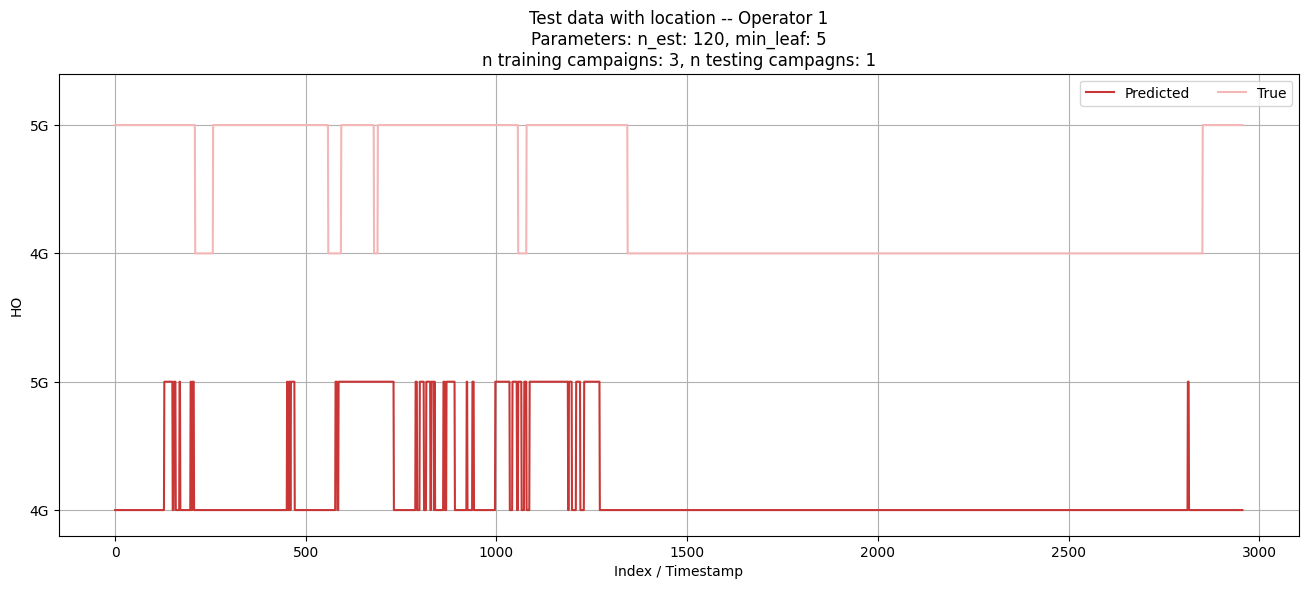

In [ ]:
selected_rf_comb = 'n_est: 120, min_leaf: 5'
rf_comb = rf_results[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rf_pred, color=mode_colors[1], label='Predicted', zorder=2)
plt.plot(rf_true.values + 2, color=mode_colors[3], label='True', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.4))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Test data with location -- {operator}\nParameters: {selected_rf_comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
plt.legend(ncols=3, loc='best')
plt.show()

### Train 4 campaigns -- Test 1 campaign

In [ ]:
new_route = read_dataset(dataset, campaigns=[overlap_1[4]])
test = read_dataset(dataset, campaigns=[overlap_1[0]])
campaigns.append(overlap_1[4])
test_campaigns = test['campaign'].unique().tolist()

new_route = new_route[5400::]

train = pd.concat([new_route, train])
train.reset_index(drop=True, inplace=True)

In [ ]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.append('campaign')
features = feature_selection[-1]

for est in est_try:
    for leaf in min_leaf_size:
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
df_rf_results

Parameters  Accuracy  Precision  Recall  Accuracy_train  \
0      n_est: 5, min_leaf: 1     0.606      0.655   0.272           0.998   
1      n_est: 5, min_leaf: 2     0.627      0.713   0.290           0.997   
2      n_est: 5, min_leaf: 5     0.625      0.684   0.317           0.993   
3      n_est: 5, min_leaf: 7     0.656      0.755   0.353           0.988   
4      n_est: 5, min_leaf: 9     0.636      0.684   0.364           0.987   
..                       ...       ...        ...     ...             ...   
72   n_est: 300, min_leaf: 5     0.635      0.730   0.307           0.996   
73   n_est: 300, min_leaf: 7     0.639      0.737   0.314           0.993   
74   n_est: 300, min_leaf: 9     0.634      0.725   0.305           0.992   
75  n_est: 300, min_leaf: 12     0.630      0.700   0.315           0.990   
76  n_est: 300, min_leaf: 15     0.635      0.714   0.323           0.989   

    Precision_train  Recall_train  
0             0.996         0.995  
1             0.990         0.995  
2             0.979         0.987  
3             0.958         0.986  
4             0.953         0.988  
..              ...           ...  
72            0.987         0.994  
73            0.978         0.991  
74            0.975         0.990  
75            0.965         0.989  
76            0.966         0.983  

[77 rows x 7 columns]

In [ ]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.633
Mean precision: 0.719
Mean recall: 0.310


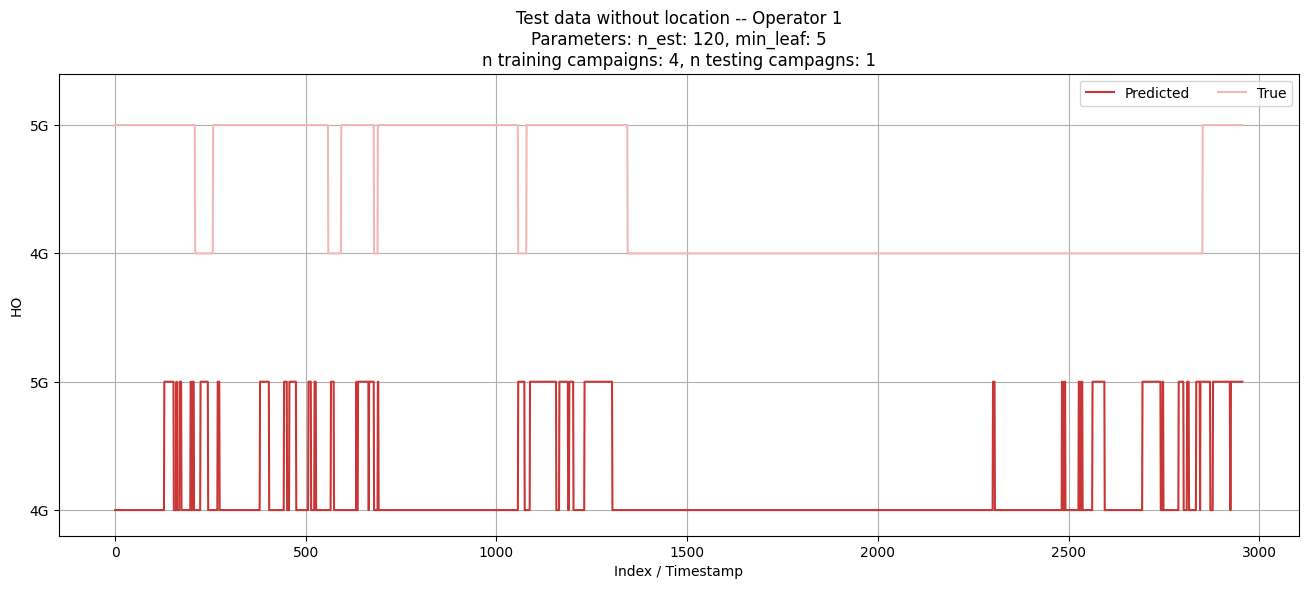

In [ ]:
selected_rf_comb = 'n_est: 120, min_leaf: 5'
rf_comb = rf_results[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rf_pred, color=mode_colors[1], label='Predicted', zorder=2)
plt.plot(rf_true.values + 2, color=mode_colors[3], label='True', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.4))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Test data without location -- {operator}\nParameters: {selected_rf_comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
plt.legend(ncols=3, loc='best')
plt.show()

#### Include location

In [ ]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.extend(['campaign', 'Latitude', 'Longitude'])
features = feature_selection[-1].copy()
features.extend(['Latitude', 'Longitude'])

for est in est_try:
    for leaf in min_leaf_size:
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=train['campaign'].unique().tolist(), test_campaigns=test['campaign'].unique().tolist(), n_estimators=est, min_samples_leaf=leaf, features=features)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
df_rf_results

Parameters  Accuracy  Precision  Recall  Accuracy_train  \
0      n_est: 5, min_leaf: 1     0.690      0.844   0.384           0.999   
1      n_est: 5, min_leaf: 2     0.735      0.848   0.502           0.998   
2      n_est: 5, min_leaf: 5     0.735      0.957   0.432           0.995   
3      n_est: 5, min_leaf: 7     0.668      0.914   0.293           0.994   
4      n_est: 5, min_leaf: 9     0.690      0.935   0.336           0.992   
..                       ...       ...        ...     ...             ...   
72   n_est: 300, min_leaf: 5     0.719      0.962   0.394           0.997   
73   n_est: 300, min_leaf: 7     0.711      0.927   0.390           0.996   
74   n_est: 300, min_leaf: 9     0.721      0.940   0.409           0.995   
75  n_est: 300, min_leaf: 12     0.734      0.935   0.441           0.993   
76  n_est: 300, min_leaf: 15     0.726      0.931   0.424           0.992   

    Precision_train  Recall_train  
0             0.999         0.996  
1             0.996         0.997  
2             0.981         0.996  
3             0.977         0.995  
4             0.969         0.995  
..              ...           ...  
72            0.990         0.998  
73            0.984         0.997  
74            0.981         0.996  
75            0.974         0.996  
76            0.968         0.996  

[77 rows x 7 columns]

In [ ]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.709
Mean precision: 0.941
Mean recall: 0.380


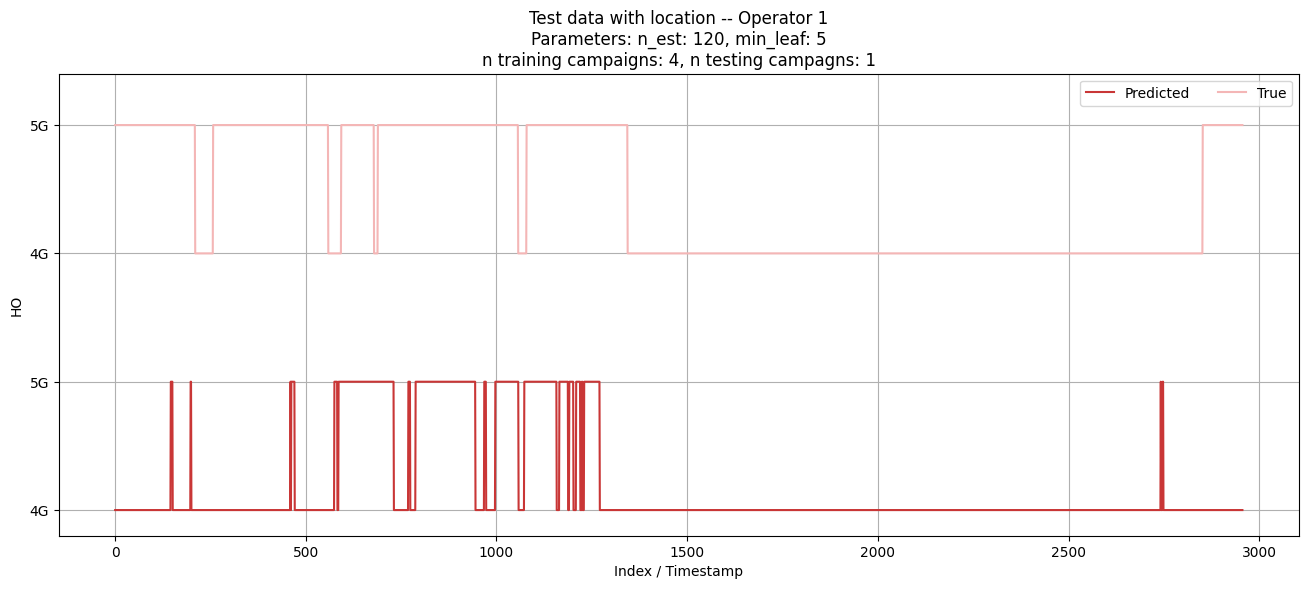

In [ ]:
selected_rf_comb = 'n_est: 120, min_leaf: 5'
rf_comb = rf_results[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rf_pred, color=mode_colors[1], label='Predicted', zorder=2)
plt.plot(rf_true.values + 2, color=mode_colors[3], label='True', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.4))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Test data with location -- {operator}\nParameters: {selected_rf_comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
plt.legend(ncols=3, loc='best')
plt.show()

### Train 5 campaigns -- Test 1 campaign

In [ ]:
new_route = read_dataset(dataset, campaigns=[overlap_1[5]])
test = read_dataset(dataset, campaigns=[overlap_1[0]])
campaigns.append(overlap_1[5])
test_campaigns = test['campaign'].unique().tolist()

new_route = new_route[0:1180]

train = pd.concat([new_route, train])
train.reset_index(drop=True, inplace=True)

fig = go.Figure()

for campaign in campaigns:
    current_route = train[train['campaign'] == campaign]
    fig.add_trace(go.Scattermapbox(lat=current_route['Latitude'], lon=current_route['Longitude'],
                                       marker = dict(
                                           opacity = 0.6,
                                           size = 3
                                       ),
                                       name=campaign))

fig.update_layout(
    height=420,
    mapbox=dict(
        style='carto-positron',
        zoom=12,
        center=dict(lon=train['Longitude'].mean(), lat=train['Latitude'].mean())
    ),
    margin=dict(
        t=1,
        b=1,
        r=1,
        l=1
    )
)
fig.show()

In [ ]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.append('campaign')
features = feature_selection[-1]

for est in est_try:
    for leaf in min_leaf_size:
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
df_rf_results

Parameters  Accuracy  Precision  Recall  Accuracy_train  \
0      n_est: 5, min_leaf: 1     0.645      0.727   0.343           0.997   
1      n_est: 5, min_leaf: 2     0.650      0.710   0.381           0.996   
2      n_est: 5, min_leaf: 5     0.637      0.685   0.363           0.991   
3      n_est: 5, min_leaf: 7     0.630      0.690   0.331           0.990   
4      n_est: 5, min_leaf: 9     0.649      0.714   0.371           0.984   
..                       ...       ...        ...     ...             ...   
72   n_est: 300, min_leaf: 5     0.652      0.743   0.350           0.995   
73   n_est: 300, min_leaf: 7     0.655      0.748   0.356           0.993   
74   n_est: 300, min_leaf: 9     0.650      0.734   0.355           0.991   
75  n_est: 300, min_leaf: 12     0.650      0.733   0.356           0.988   
76  n_est: 300, min_leaf: 15     0.638      0.707   0.339           0.985   

    Precision_train  Recall_train  
0             0.992         0.995  
1             0.987         0.996  
2             0.969         0.993  
3             0.966         0.992  
4             0.947         0.986  
..              ...           ...  
72            0.985         0.994  
73            0.978         0.994  
74            0.967         0.992  
75            0.963         0.987  
76            0.950         0.986  

[77 rows x 7 columns]

In [ ]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.646
Mean precision: 0.727
Mean recall: 0.346


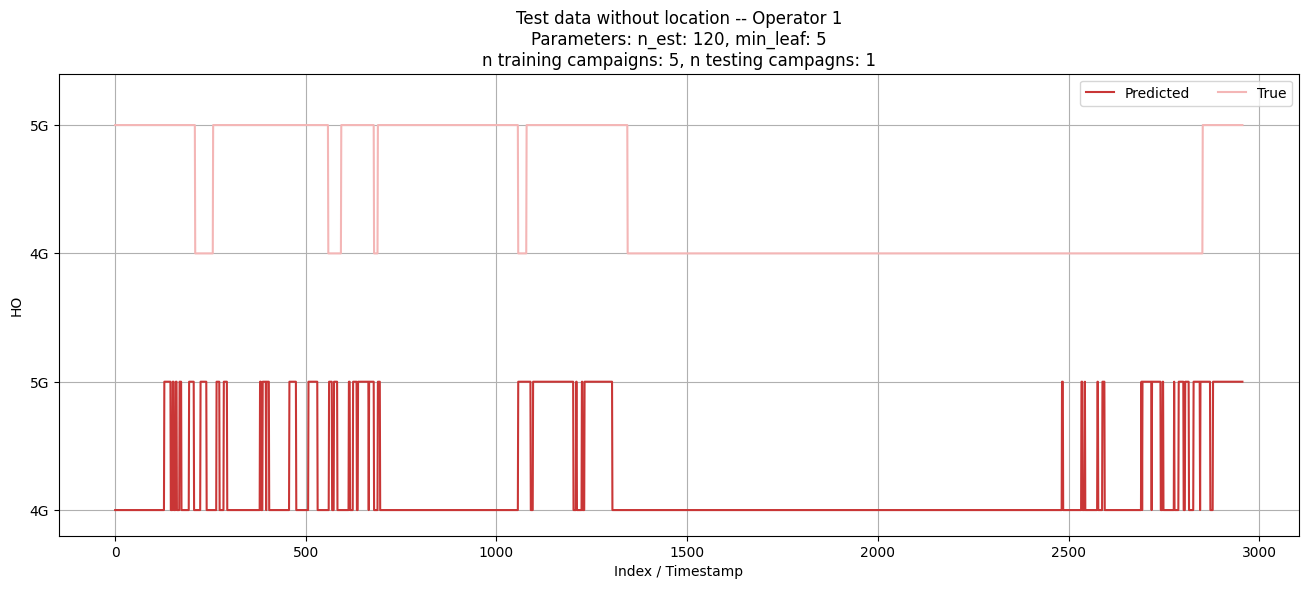

In [ ]:
selected_rf_comb = 'n_est: 120, min_leaf: 5'
rf_comb = rf_results[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rf_pred, color=mode_colors[1], label='Predicted', zorder=2)
plt.plot(rf_true.values + 2, color=mode_colors[3], label='True', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.4))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Test data without location -- {operator}\nParameters: {selected_rf_comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
plt.legend(ncols=3, loc='best')
plt.show()

#### Include location

In [ ]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.extend(['campaign', 'Latitude', 'Longitude'])
features = feature_selection[-1].copy()
features.extend(['Latitude', 'Longitude'])

for est in est_try:
    for leaf in min_leaf_size:
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=train['campaign'].unique().tolist(), test_campaigns=test['campaign'].unique().tolist(), n_estimators=est, min_samples_leaf=leaf, features=features)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
df_rf_results

Parameters  Accuracy  Precision  Recall  Accuracy_train  \
0      n_est: 5, min_leaf: 1     0.699      0.949   0.352           0.999   
1      n_est: 5, min_leaf: 2     0.639      0.815   0.261           0.998   
2      n_est: 5, min_leaf: 5     0.744      0.908   0.482           0.997   
3      n_est: 5, min_leaf: 7     0.658      0.890   0.278           0.996   
4      n_est: 5, min_leaf: 9     0.792      0.937   0.579           0.993   
..                       ...       ...        ...     ...             ...   
72   n_est: 300, min_leaf: 5     0.724      0.951   0.410           0.997   
73   n_est: 300, min_leaf: 7     0.732      0.944   0.433           0.996   
74   n_est: 300, min_leaf: 9     0.689      0.899   0.352           0.995   
75  n_est: 300, min_leaf: 12     0.738      0.946   0.445           0.994   
76  n_est: 300, min_leaf: 15     0.739      0.921   0.461           0.992   

    Precision_train  Recall_train  
0             0.998         0.998  
1             0.994         0.996  
2             0.990         0.998  
3             0.983         0.997  
4             0.974         0.996  
..              ...           ...  
72            0.990         0.998  
73            0.985         0.998  
74            0.981         0.997  
75            0.977         0.998  
76            0.971         0.996  

[77 rows x 7 columns]

In [ ]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.714
Mean precision: 0.934
Mean recall: 0.396


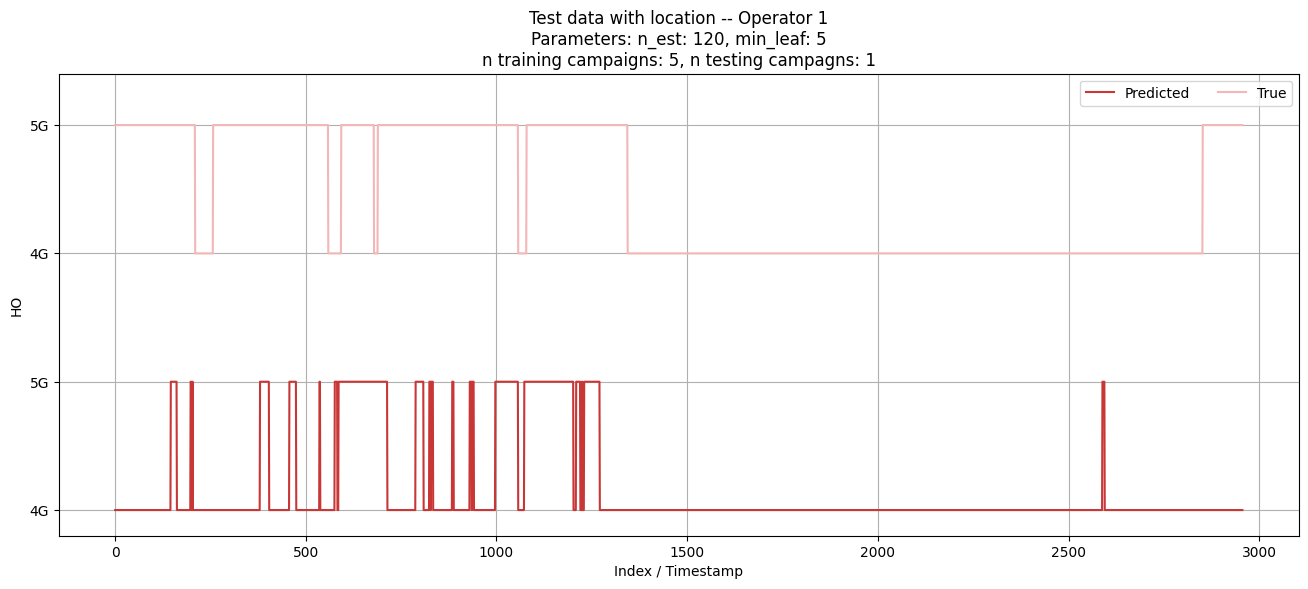

In [ ]:
selected_rf_comb = 'n_est: 120, min_leaf: 5'
rf_comb = rf_results[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rf_pred, color=mode_colors[1], label='Predicted', zorder=2)
plt.plot(rf_true.values + 2, color=mode_colors[3], label='True', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.4))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Test data with location -- {operator}\nParameters: {selected_rf_comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
plt.legend(ncols=3, loc='best')
plt.show()

### Overlap 2

In [ ]:
train = read_dataset(dataset, campaigns=[overlap_2[0]])
test = read_dataset(dataset, campaigns=[overlap_2[1]])
campaigns = train['campaign'].unique().tolist()
test_campaigns = test['campaign'].unique().tolist()

In [ ]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.append('campaign')
features = feature_selection[-1]

for est in est_try:
    for leaf in min_leaf_size:
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
df_rf_results

Parameters  Accuracy  Precision  Recall  Accuracy_train  \
0      n_est: 5, min_leaf: 1     0.839        0.0     0.0           1.000   
1      n_est: 5, min_leaf: 2     0.861        0.0     0.0           0.998   
2      n_est: 5, min_leaf: 5     0.839        0.0     0.0           0.998   
3      n_est: 5, min_leaf: 7     0.862        0.0     0.0           0.997   
4      n_est: 5, min_leaf: 9     0.842        0.0     0.0           0.997   
..                       ...       ...        ...     ...             ...   
72   n_est: 300, min_leaf: 5     0.852        0.0     0.0           0.999   
73   n_est: 300, min_leaf: 7     0.843        0.0     0.0           0.998   
74   n_est: 300, min_leaf: 9     0.844        0.0     0.0           0.997   
75  n_est: 300, min_leaf: 12     0.839        0.0     0.0           0.996   
76  n_est: 300, min_leaf: 15     0.832        0.0     0.0           0.993   

    Precision_train  Recall_train  
0             0.999         1.000  
1             0.996         0.999  
2             0.996         0.996  
3             0.996         0.992  
4             0.991         0.996  
..              ...           ...  
72            0.999         0.998  
73            0.994         0.998  
74            0.996         0.993  
75            0.990         0.994  
76            0.983         0.993  

[77 rows x 7 columns]

In [ ]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.847
Mean precision: 0.000
Mean recall: 0.000


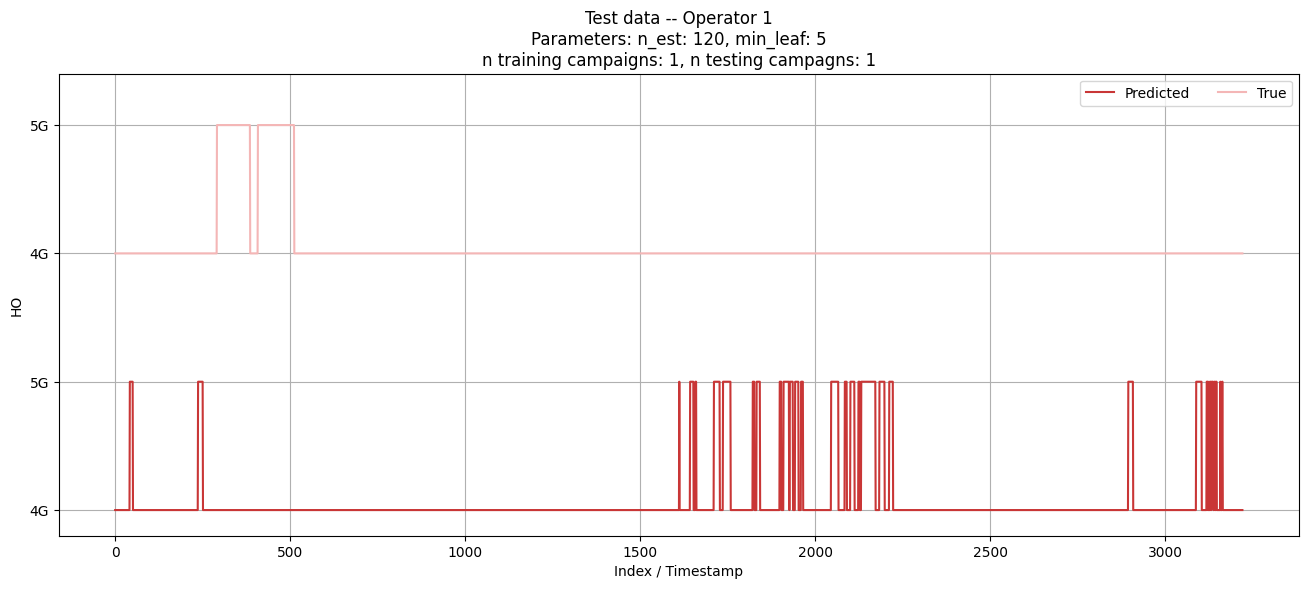

In [ ]:
selected_rf_comb = 'n_est: 120, min_leaf: 5'
rf_comb = rf_results[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rf_pred, color=mode_colors[1], label='Predicted', zorder=2)
plt.plot(rf_true.values + 2, color=mode_colors[3], label='True', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.4))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Test data -- {operator}\nParameters: {selected_rf_comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
plt.legend(ncols=3, loc='best')
plt.show()

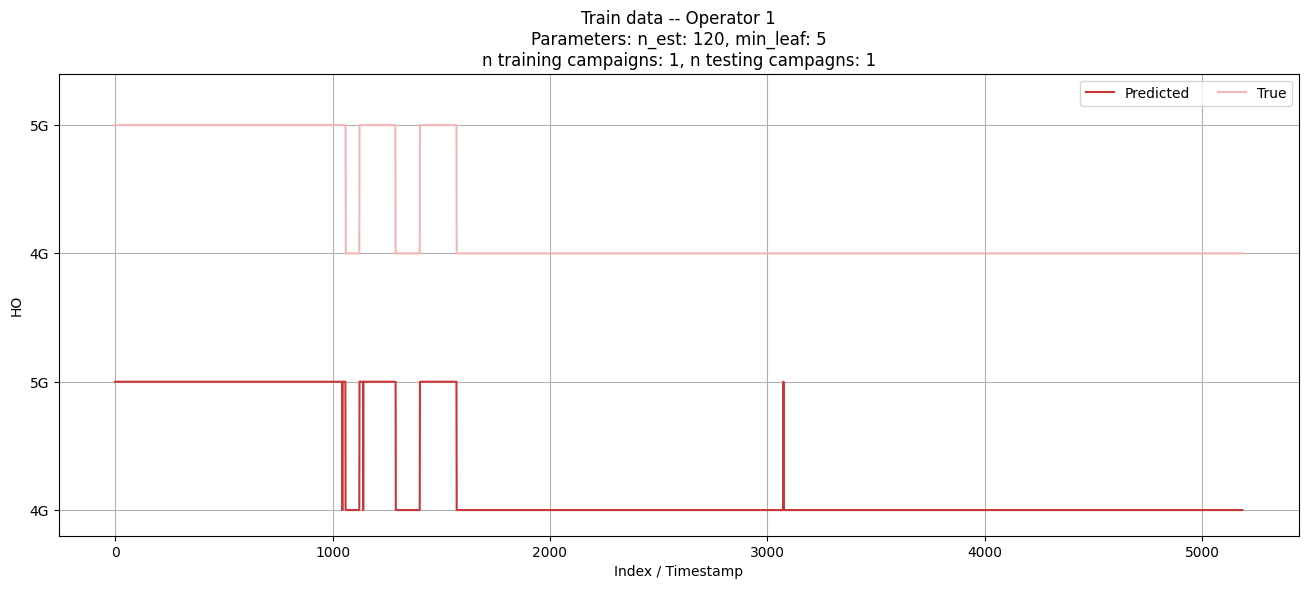

In [ ]:
rf_pred_train = rf_comb['train_pred']
rf_true_train = rf_comb['train_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rf_pred_train, color=mode_colors[1], label='Predicted', zorder=2)
plt.plot(rf_true_train.values + 2, color=mode_colors[3], label='True', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.4))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Train data -- {operator}\nParameters: {selected_rf_comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
plt.legend(ncols=3, loc='best')
plt.show()

#### Include location

In [ ]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.extend(['campaign', 'Latitude', 'Longitude'])
features = feature_selection[-1].copy()
features.extend(['Latitude', 'Longitude'])

for est in est_try:
    for leaf in min_leaf_size:
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=train['campaign'].unique().tolist(), test_campaigns=test['campaign'].unique().tolist(), n_estimators=est, min_samples_leaf=leaf, features=features)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
df_rf_results

Parameters  Accuracy  Precision  Recall  Accuracy_train  \
0      n_est: 5, min_leaf: 1     0.932        0.0     0.0           1.000   
1      n_est: 5, min_leaf: 2     0.930        0.0     0.0           1.000   
2      n_est: 5, min_leaf: 5     0.925        0.0     0.0           0.999   
3      n_est: 5, min_leaf: 7     0.934        0.0     0.0           0.999   
4      n_est: 5, min_leaf: 9     0.931        0.0     0.0           0.998   
..                       ...       ...        ...     ...             ...   
72   n_est: 300, min_leaf: 5     0.929        0.0     0.0           1.000   
73   n_est: 300, min_leaf: 7     0.933        0.0     0.0           1.000   
74   n_est: 300, min_leaf: 9     0.932        0.0     0.0           1.000   
75  n_est: 300, min_leaf: 12     0.932        0.0     0.0           1.000   
76  n_est: 300, min_leaf: 15     0.930        0.0     0.0           0.999   

    Precision_train  Recall_train  
0             0.999         1.000  
1             1.000         1.000  
2             0.997         1.000  
3             0.998         0.999  
4             0.994         0.999  
..              ...           ...  
72            1.000         1.000  
73            1.000         1.000  
74            1.000         1.000  
75            0.999         1.000  
76            0.996         1.000  

[77 rows x 7 columns]

In [ ]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.931
Mean precision: 0.000
Mean recall: 0.000


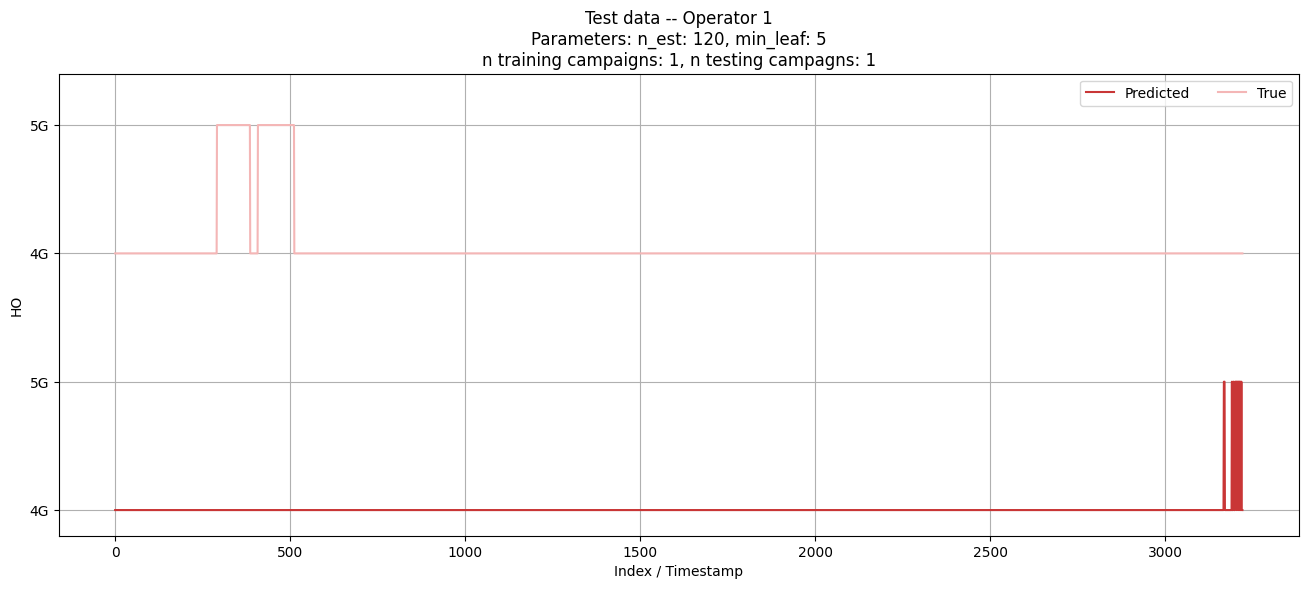

In [ ]:
selected_rf_comb = 'n_est: 120, min_leaf: 5'
rf_comb = rf_results[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rf_pred, color=mode_colors[1], label='Predicted', zorder=2)
plt.plot(rf_true.values + 2, color=mode_colors[3], label='True', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.4))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Test data -- {operator}\nParameters: {selected_rf_comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
plt.legend(ncols=3, loc='best')
plt.show()

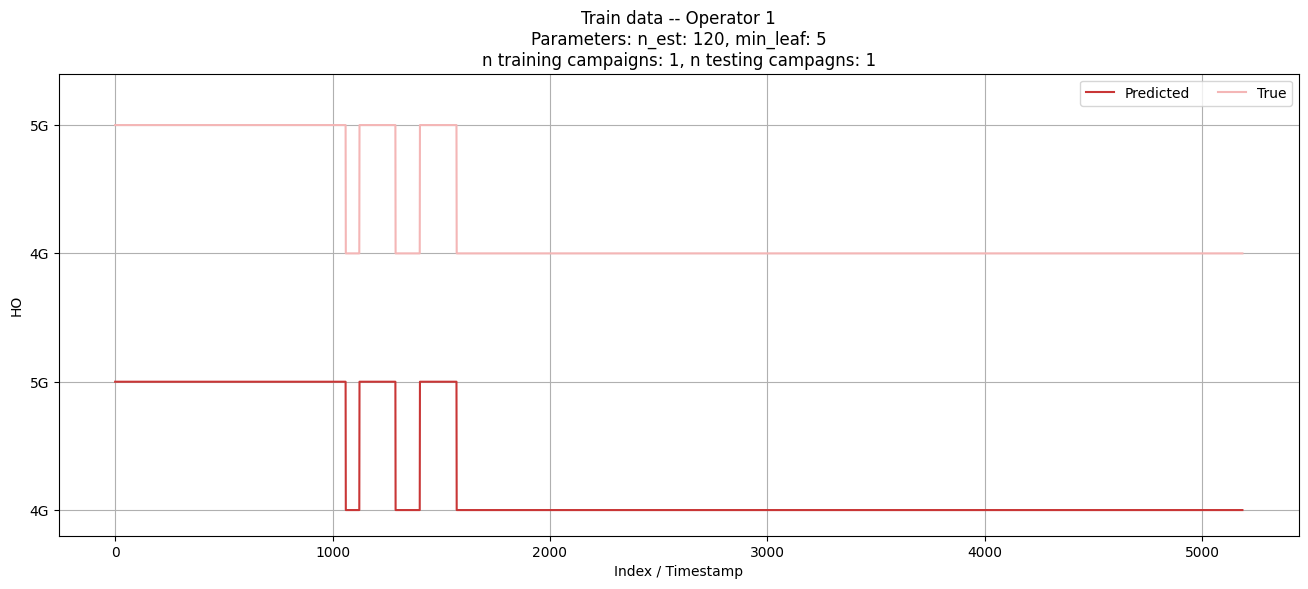

In [ ]:
rf_pred_train = rf_comb['train_pred']
rf_true_train = rf_comb['train_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
plt.plot(rf_pred_train, color=mode_colors[1], label='Predicted', zorder=2)
plt.plot(rf_true_train.values + 2, color=mode_colors[3], label='True', zorder=3)
plt.xlabel('Index / Timestamp')
plt.ylabel('HO')
plt.ylim((-0.2, 3.4))
plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
plt.title(f'Train data -- {operator}\nParameters: {selected_rf_comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
plt.legend(ncols=3, loc='best')
plt.show()